In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=1f82fb7a78eff37eba32b02bfdb709d2eb830fdfd5d8eea2090e981b9462725d
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [27]:
# importing required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
import re
import string

In [28]:
# # Root dir
# ROOT_DIR = "/content/drive/My Drive/QuerySupport"

In [29]:
# Reading Dataset
data = pd.read_csv('/content/sample_data/Tweets.csv')

In [30]:
# Reading top rows
data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0.0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0.0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [31]:
# we check how much null entries in each columns
print("data_is_null \n",data.isnull().sum())

data_is_null 
 tweet_id                          568
airline_sentiment                   0
airline_sentiment_confidence      568
negativereason                   5485
negativereason_confidence        4686
airline                            23
airline_sentiment_gold          15168
name                              515
negativereason_gold             15176
retweet_count                     568
text                               23
tweet_coord                     14189
tweet_created                     568
tweet_location                   5301
user_timezone                    5388
dtype: int64


In [32]:
 #Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [33]:
data['text'].values

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ..., nan, nan, nan], dtype=object)

In [34]:
data.describe()

,text,airline_sentiment
count,15185,15208
unique,14891,3
top,Why am I unable to book a flight for an unacco...,negative
freq,8,9746


In [35]:
# it will remove all Neutral values from data
data = data[data.airline_sentiment != "neutral"].copy()


In [36]:
data.describe()

,text,airline_sentiment
count,12086,12109
unique,11845,2
top,Why am I unable to book a flight for an unacco...,negative
freq,8,9746


In [37]:
import nltk
# nltk.download('stopwords')
from nltk import PorterStemmer

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
# Cleaning Text

def clean_text(txt):

          """
          removing all hashtags , punctuations, stop_words  and links, also stemming words
          """
          from nltk.corpus import stopwords
          txt = txt.lower()
          txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot
          txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
          txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie
          txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
          txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
          txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
          txt = re.sub(r"(http\S+|http)", "", txt) # remove links
          txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
          txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
          return txt

In [40]:
# Data Cleaning
data = data[data['text'].notnull()]
data['text'] = data['text'].apply(clean_text)

In [41]:
data['text'].values

array(['plu ad commerci experi tacki',
       'realli aggress blast obnoxi enotertainmenot guest face amp littl recours',
       'realli big bad thing', ...,
       'book flight pet find add pet detail assist need',
       'websit keep redirect back flight select page glitch',
       'tri book flight websit accept credit card detail known paymenot issu'],
      dtype=object)

In [42]:
# Embedding words to text sequences
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

# pad: to make all input of same length
X = pad_sequences(X)

In [43]:
X.shape

(12086, 21)

In [44]:
embed_dim = 128
lstm_out = 196
input_len = 21
import time
model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))


In [45]:
start=time.time()
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print("Time to compile model:",time.time()-start)


Time to compile model: 0.012475967407226562


In [46]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 21, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511194 (1.95 MB)
Trainable params: 511194 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [50]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, Y_train, y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)
print('Train Set ->', X_train.shape, Y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, Y_test.shape)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Train Set -> (8218, 21) (8218, 2)
Validation Set -> (2055, 21) (2055, 2)
Test Set -> (1813, 21) (1813, 2)
(8218, 21) (8218, 2)
(1813, 21) (1813, 2)


In [51]:

from tqdm import tqdm
from keras.callbacks import LambdaCallback

batch_size = 32
epoch_list = []
loss_list = []
# Define a function to print loss after every epoch
def print_loss(epoch, logs):
    print(f'Epoch {epoch+1}/{epochs}, Loss: {logs["loss"]}')
    epoch_list.append(epoch + 1)  # Epochs start from 1
    loss_list.append(logs["loss"])
# Define the number of epochs
epochs = 40

# Fit the model with a callback to print loss after every epoch
history = model.fit(X_train, Y_train, validation_data=(X_val, y_val),
          epochs=epochs,
          batch_size=batch_size,
          verbose=2,
          callbacks=[LambdaCallback(on_epoch_end=print_loss)])

Epoch 1/40
Epoch 1/40, Loss: 0.343051016330719
257/257 - 30s - loss: 0.3431 - accuracy: 0.8647 - val_loss: 0.2433 - val_accuracy: 0.9022 - 30s/epoch - 118ms/step
Epoch 2/40
Epoch 2/40, Loss: 0.18141868710517883
257/257 - 17s - loss: 0.1814 - accuracy: 0.9288 - val_loss: 0.2620 - val_accuracy: 0.9017 - 17s/epoch - 68ms/step
Epoch 3/40
Epoch 3/40, Loss: 0.1438315063714981
257/257 - 19s - loss: 0.1438 - accuracy: 0.9454 - val_loss: 0.2570 - val_accuracy: 0.8983 - 19s/epoch - 74ms/step
Epoch 4/40
Epoch 4/40, Loss: 0.11798874288797379
257/257 - 19s - loss: 0.1180 - accuracy: 0.9542 - val_loss: 0.2945 - val_accuracy: 0.8998 - 19s/epoch - 73ms/step
Epoch 5/40
Epoch 5/40, Loss: 0.10127769410610199
257/257 - 19s - loss: 0.1013 - accuracy: 0.9631 - val_loss: 0.3085 - val_accuracy: 0.8964 - 19s/epoch - 75ms/step
Epoch 6/40
Epoch 6/40, Loss: 0.08769460767507553
257/257 - 18s - loss: 0.0877 - accuracy: 0.9665 - val_loss: 0.3914 - val_accuracy: 0.8895 - 18s/epoch - 72ms/step
Epoch 7/40
Epoch 7/40, L

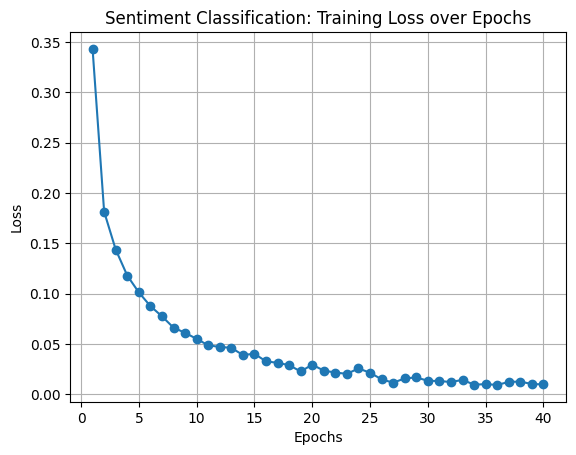

In [52]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Sentiment Classification: Training Loss over Epochs')
plt.grid(True)
plt.show()

In [24]:
# Plotting the loss vs epochs
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')
# plt.show()

NameError: name 'history' is not defined

In [24]:
# from tqdm import tqdm
# batch_size = 32
# tqdm(model.fit(X_train, Y_train, epochs = 40, batch_size=batch_size, verbose = 2))

Epoch 1/40


KeyboardInterrupt: 

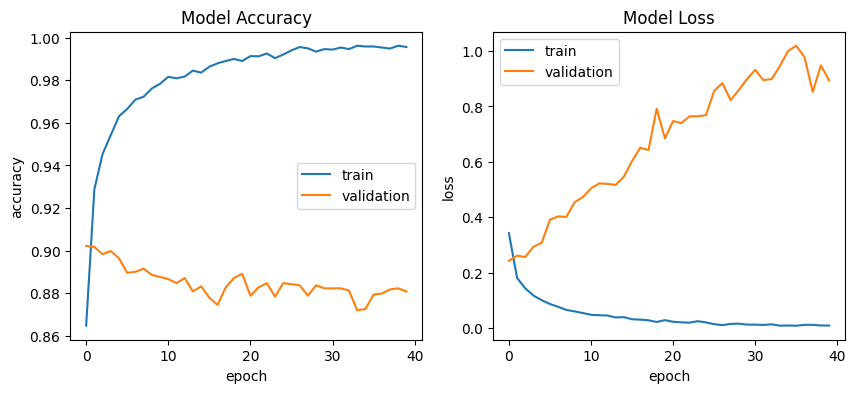

In [53]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

In [28]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Loss value: %.2f" % (score))
print("acc: %.2f" % (acc))

57/57 - 1s - loss: 0.8699 - accuracy: 0.9145 - 774ms/epoch - 14ms/step
Loss value: 0.87
acc: 0.91


In [29]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

In [30]:
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 73.10344827586206 %
neg_acc 95.86776859504133 %


In [31]:
twt = ['@united such not bad service']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 0)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 119]]
negative


In [32]:
import pickle

#saving model
model.save(ROOT_DIR+"binaryClassificationModel.h5")

# saving tokenizer
with open(ROOT_DIR+'tokenizerBinaryClassification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 1s 11ms/step


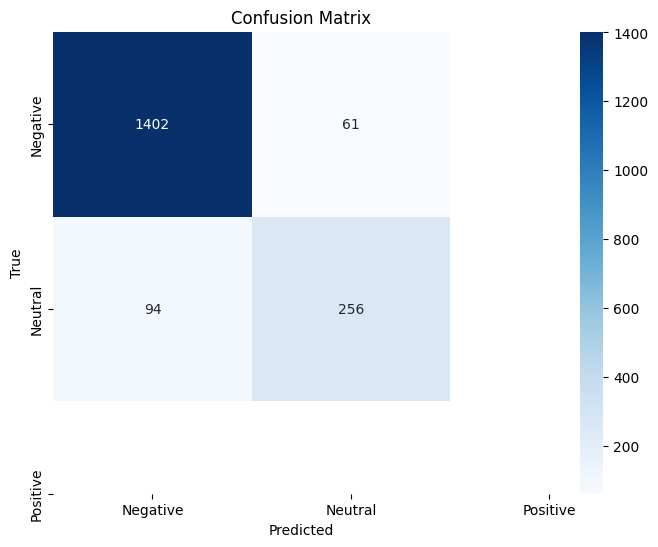

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert one-hot encoded labels to binary labels
Y_test_classes = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, y_pred_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [34]:
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print(f'True positive: {TP}')
print(f'True negative: {TN}')
print(f'False positive: {FP}')
print(f'False negative: {FN}')

True positive: 256
True negative: 1402
False positive: 61
False negative: 94


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(Y_test_classes, y_pred_classes)
recall = recall_score(Y_test_classes, y_pred_classes)
f1 = f1_score(Y_test_classes, y_pred_classes)

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

Precision: 0.808
Recall: 0.731
F1-score: 0.768
